In [1]:
import mediapipe as mp
import cv2
import numpy as np
import os
import pandas as pd
# import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import sys
from sklearn.neighbors import KernelDensity
import warnings
from itertools import count
import pickle
warnings.filterwarnings("ignore")

In [2]:
autoencoder_model = tf.keras.models.load_model('../Predict/autoencoder500epoch.keras')
encoder_model = tf.keras.models.load_model('../Predict/encoder500epoch.keras')
with open('../Deadlift Stages/deadlift_bot_rf.pkl', 'rb') as f:
    model_rf = pickle.load(f)

2023-08-23 21:21:42.094933: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-23 21:21:42.094980: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-23 21:21:42.094990: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-23 21:21:42.095144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 21:21:42.095409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
deadlift_path = "Correct/"
anomaly_path = "Anomaly/"

In [4]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path,out_vector_shape,kde):
    density_threshold = -240000 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.032# Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((256,256)))
    # plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = autoencoder_model.predict([[img]])
    reconstruction_error = autoencoder_model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    # print('reconstruction_error: ', reconstruction_error)
    # print('density: ', density)
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return "Anomaly"
        
    else:
        return "Good Deadlift Form"

In [5]:
# Image_folder = "../Data/Orientation/Data/deadlift/"
train_folder = "../Data/Orientation/Data/train"
valid_folder = "../Data/Orientation/Data/valid"
anomaly_folder = "../Data/Orientation/anomaly"
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    directory=train_folder,
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)

valid_generator = datagen.flow_from_directory(
    directory=valid_folder,
    # target_size=(45,100),
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)

anomaly_generator = datagen.flow_from_directory(
    directory=anomaly_folder,
    # target_size=(45,100),
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)

Found 199 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [6]:
#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)



2023-08-23 21:24:58.536354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [8]:
deadlifts = []
file_dir = sorted(os.listdir(deadlift_path))
for file in file_dir:
    if file.endswith(".png"):
        # print(file)
        deadlifts.append(check_anomaly(os.path.join(deadlift_path,file),out_vector_shape,kde))
deadlifts

1/1 [==============================] - 0s 23ms/step - loss: 0.0176 - mse: 0.0176


['Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Anomaly',
 'Good Deadlift Form',
 'Anomaly',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Anomaly',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Anomaly',
 'Anomaly',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form',
 'Good Deadlift Form']

In [11]:
anomalies = []
file_dir = sorted(os.listdir(anomaly_path))
for file in file_dir:
    if file.endswith(".png"):
        # print(file)
        anomalies.append(check_anomaly(os.path.join(anomaly_path,file),out_vector_shape,kde))
anomalies

1/1 [==============================] - 0s 25ms/step - loss: 0.0150 - mse: 0.0150


['Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Anomaly',
 'Good Deadlift Form']

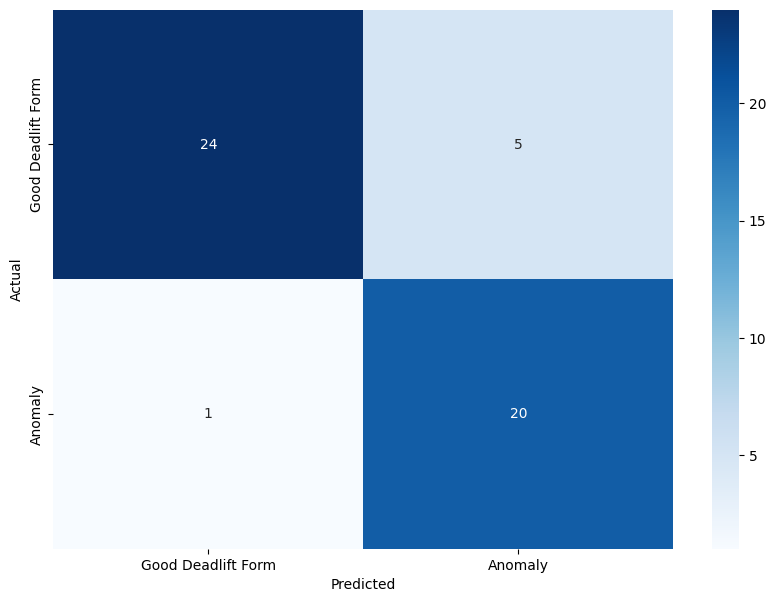

In [14]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

y_true = ['Good Deadlift Form']*len(deadlifts) + ['Anomaly']*len(anomalies)
y_pred = deadlifts + anomalies

cm = confusion_matrix(y_true, y_pred, labels=['Good Deadlift Form', 'Anomaly'])
df_cm = pd.DataFrame(cm, index = ['Good Deadlift Form', 'Anomaly'],
                    columns = ['Good Deadlift Form', 'Anomaly'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=['Good Deadlift Form', 'Anomaly']))


                    precision    recall  f1-score   support

Good Deadlift Form       0.96      0.83      0.89        29
           Anomaly       0.80      0.95      0.87        21

          accuracy                           0.88        50
         macro avg       0.88      0.89      0.88        50
      weighted avg       0.89      0.88      0.88        50

